# Restaurant Comment Analysis

<img src='https://assets.simpleviewcms.com/simpleview/image/fetch/c_pad,h_600,q_75,w_1122/https://lasvegas.simpleviewcrm.com/images/listings/original_Bacchanal-Buffet-at-Caesars-Palace.jpg'/>

### Importing Required Packages

In [28]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
warnings.filterwarnings("ignore")

## Load the data

In [29]:
df = pd.read_csv('restaurant.csv')

## Remember

##### Things to consider when starting an NLP project

* Convert everything to lowercase
* remove punctuation marks
* remove digits
* remove line breaks \n
*  stopwords remove unnecessary words
* Tokenize
*  Remove suffixes and find roots with lemma and stemma
* Vectorize

## EDA - Exploratory Data Analysis

In [30]:
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,2370338,_WTGv5XnA-qb_XD1D7Z0jg,6PgdGb3HrZdsfl2GiULo8w,RESDUcs7fIiihp38-d6_6g,5,0,1,0,After getting food poisoning at the Palms hote...,2012-12-04 03:10:18
1,2370357,JlNnsvMPLK_1-X2hwzK24w,IS9yw8P2uAPBX6FNLLX4KA,RESDUcs7fIiihp38-d6_6g,4,39,21,29,"""A feast worthy of Gods""\n\nBaccarnal Buffet i...",2014-01-17 00:50:50
2,2370373,hBkoWffORRb6aqKhC_Li2A,uZdFsE_aHbFBChgN6Xa8tw,RESDUcs7fIiihp38-d6_6g,4,1,1,1,The crab legs are better than the ones at Wick...,2015-06-08 18:03:09
3,2370411,rbkxvrgZg5kdCL2a66QYmA,8ZWJNAEWsymXDzKx3B0tTQ,RESDUcs7fIiihp38-d6_6g,1,0,0,0,Not worth it! Too salty food and expensive! Th...,2016-12-19 16:15:29
4,2370500,5tw_pedoHVi9bgeiBNsISg,E0sm4Ve7ifanFYeQMcV8Eg,RESDUcs7fIiihp38-d6_6g,5,0,0,0,I would give this infinite stars if I could. M...,2015-07-28 07:13:17


In [31]:
# Drop the columns that are not required
df = df.drop(['Unnamed: 0','business_id', 'review_id', 'user_id'], axis=1)

In [32]:
df.shape

(10417, 6)

In [33]:
df.sample(5)

,stars,useful,funny,cool,text,date
4585,2,3,1,1,Came here after reading all of the yummy revie...,2013-01-11 05:52:40
8687,5,11,10,11,Oh Bacchanal Buffet!!!\nHow do I love thee? L...,2014-02-25 01:25:28
5921,4,13,7,14,********************* 1302 *******************...,2015-05-11 01:40:35
618,3,8,6,5,This was on my MUST DO list of gluttonous thin...,2016-01-31 01:18:29
756,1,0,0,0,Still charging holiday brunch prices the day a...,2016-07-05 17:15:14


In [34]:
df.isnull().sum()

stars     0
useful    0
funny     0
cool      0
text      0
date      0
dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10417 entries, 0 to 10416
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   stars   10417 non-null  int64 
 1   useful  10417 non-null  int64 
 2   funny   10417 non-null  int64 
 3   cool    10417 non-null  int64 
 4   text    10417 non-null  object
 5   date    10417 non-null  object
dtypes: int64(4), object(2)
memory usage: 488.4+ KB


In [36]:
df.describe()

,stars,useful,funny,cool
count,10417.000000,10417.000000,10417.000000,10417.000000
mean,3.777671,1.419603,0.640875,0.759720
std,1.331451,4.875888,3.347964,4.125847
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,176.000000,159.000000,172.000000


In [37]:
df['date'] = pd.to_datetime(df['date'])

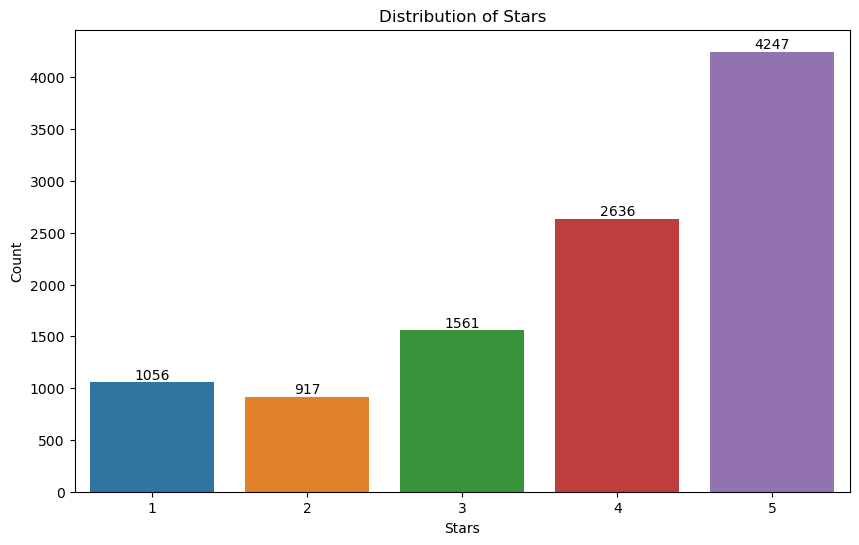

In [38]:
# Distribution of Stars
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=df['stars'])
ax.bar_label(ax.containers[0])
plt.title('Distribution of Stars')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()


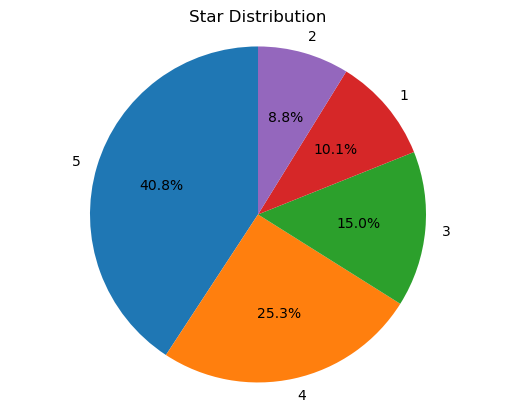

In [39]:
stars_counts = df['stars'].value_counts()
labels = stars_counts.index
sizes = stars_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Star Distribution')
plt.show()

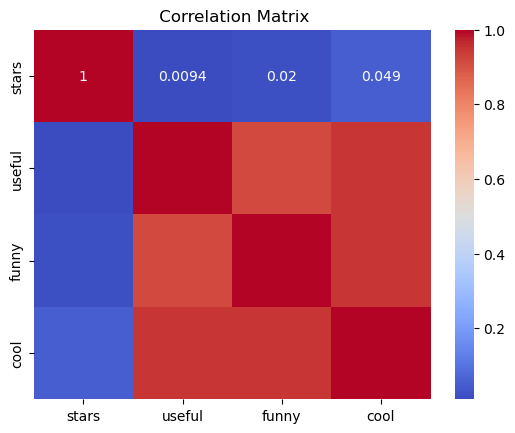

In [40]:
# Correlation Matrix
correlation = df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title(' Correlation Matrix')
plt.show()

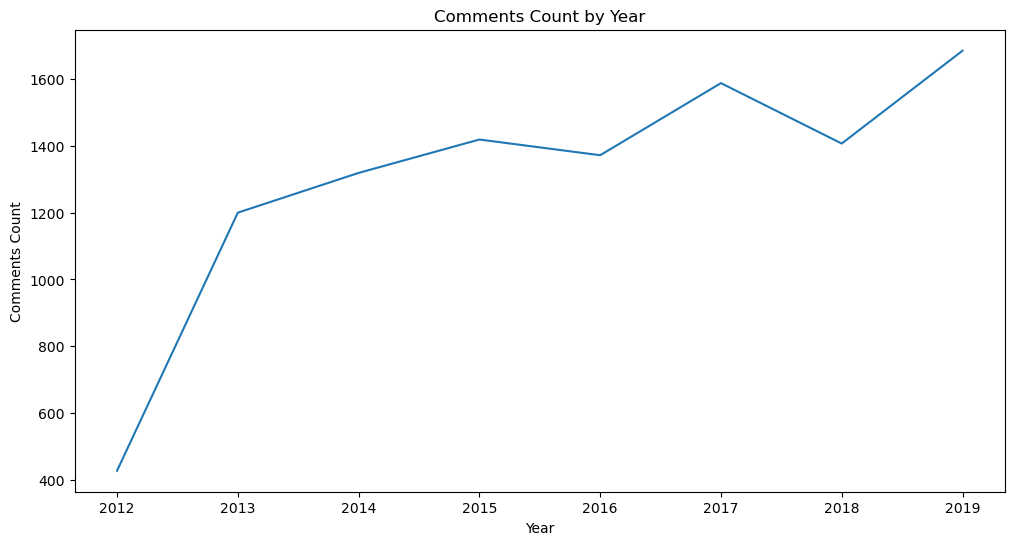

In [41]:
# Comments Count by Year

df['year'] = df['date'].dt.year
yearly_reviews = df.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='count', data=yearly_reviews)
plt.title('Comments Count by Year')
plt.xlabel('Year')
plt.ylabel('Comments Count')
plt.show()

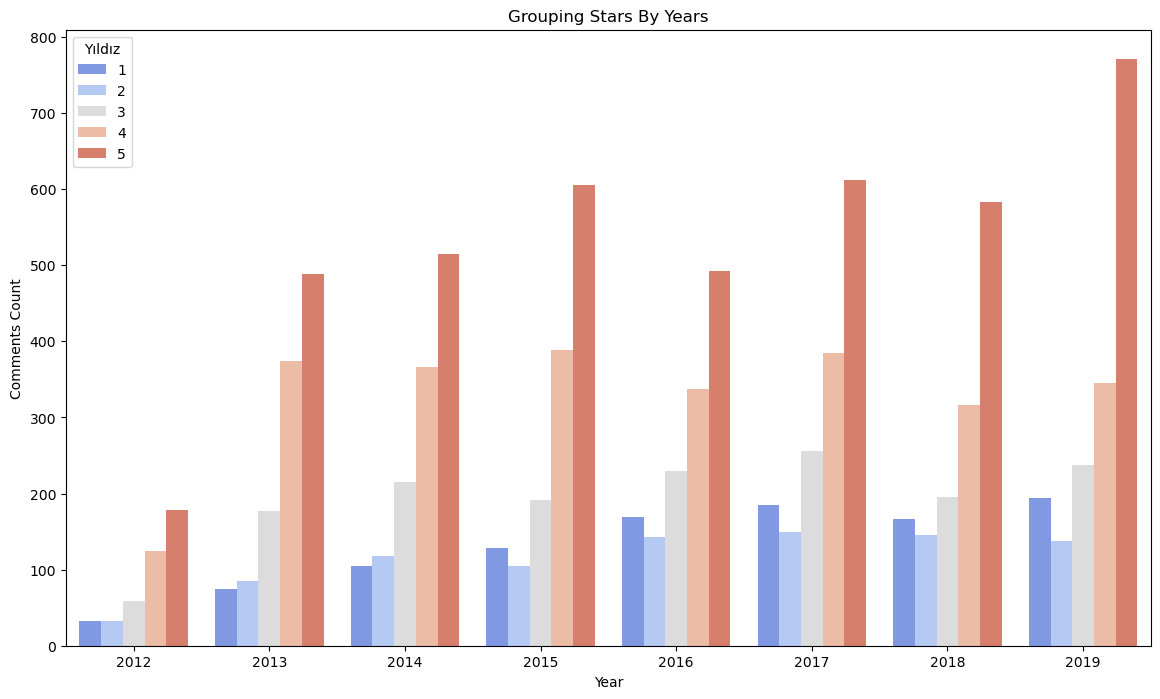

In [42]:
# Grouping stars by years
yearly_star_counts = df.groupby(['year', 'stars']).size().reset_index(name='count')
yearly_star_counts['year'] = yearly_star_counts['year'].astype(str)
yearly_star_counts['stars'] = yearly_star_counts['stars'].astype(str)

plt.figure(figsize=(14, 8))
sns.barplot(x='year', y='count', hue='stars', data=yearly_star_counts, palette='coolwarm')
plt.title('Grouping Stars By Years')
plt.xlabel('Year')
plt.ylabel('Comments Count')
plt.legend(title='Yıldız')
plt.show();

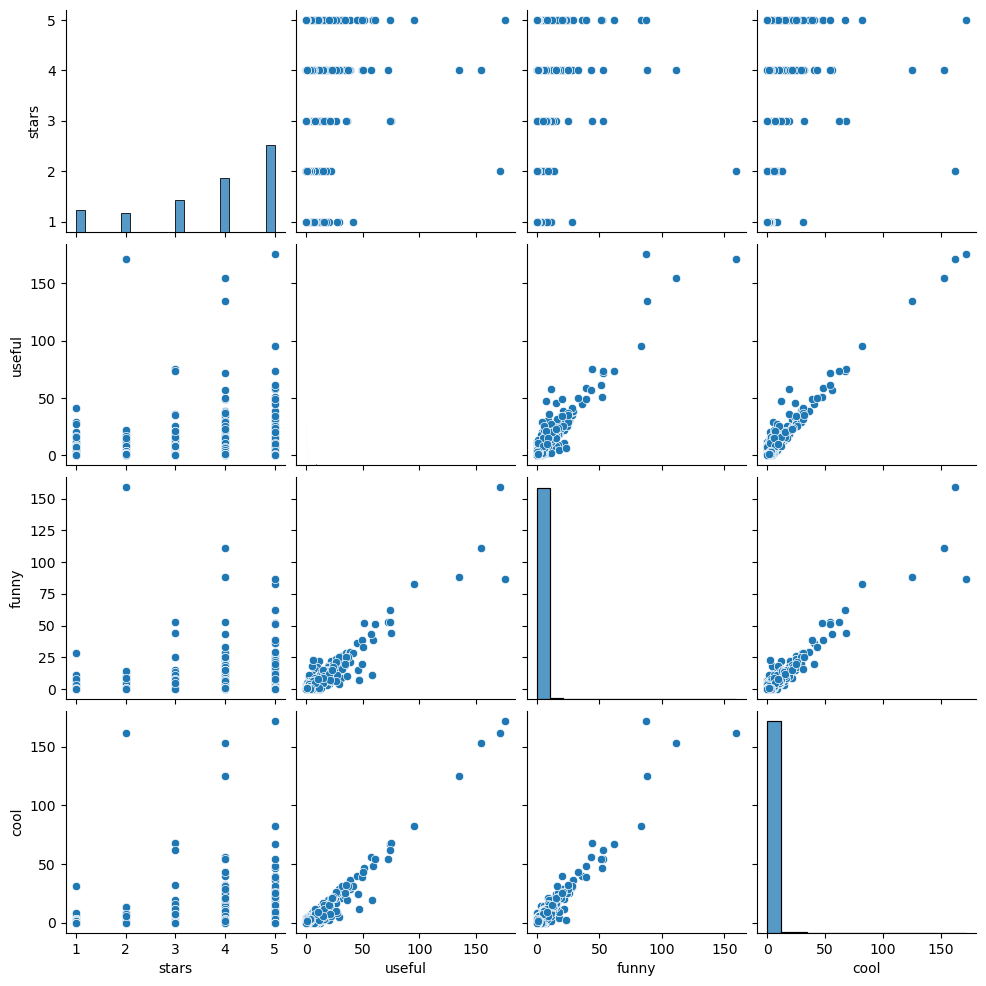

In [43]:
sns.pairplot(df[['stars', 'useful', 'funny', 'cool']])
plt.show()

### Sentiment Column
 A sentiment column was created according to the stars.
* 1-2 stars negative,
* 3 stars neutral, 
* 4-5 stars positive were marked.

In [44]:
# add sentiment column
df['sentiment'] = df['stars'].apply(lambda x: 'positive' if x > 3 else 'neutral' if x == 3 else 'negative')
df = df.reindex(columns=['stars','sentiment'] + [col for col in df.columns if col != 'sentiment' and col != 'stars'])
df.sentiment = df.sentiment.astype('category')

In [45]:
df.sample(10)

,stars,sentiment,useful,funny,cool,text,date,year
136,1,negative,0,0,0,Incredibly overpriced for the quality. Tourist...,2013-12-29 02:15:12,2013
3972,4,positive,2,0,0,I wasn't planning to do buffet at all but I gu...,2012-10-22 18:06:03,2012
1364,1,negative,0,0,0,I was really looking forward to coming here. ...,2015-04-18 01:37:17,2015
5024,4,positive,0,0,0,This place lives up to its reputation as the b...,2018-04-12 00:48:39,2018
2798,4,positive,0,0,0,No question food is best of any buffet in town...,2018-04-19 20:42:58,2018
9206,5,positive,0,0,0,Excellent service. Came at 2pm on a weekday s...,2019-10-22 23:05:21,2019
3844,4,positive,1,2,1,The only city where I like buffets ... VEGAS!!...,2013-10-31 22:02:08,2013
10025,1,negative,0,0,0,The seafood at this place tasted really fishy ...,2019-01-31 00:15:33,2019
5582,5,positive,0,0,0,Best buffet in Vegas. I come here everytime I'...,2015-12-04 01:57:46,2015
750,5,positive,0,0,0,"Okay, how can anyone not love this place???\n\...",2014-01-19 20:46:41,2014


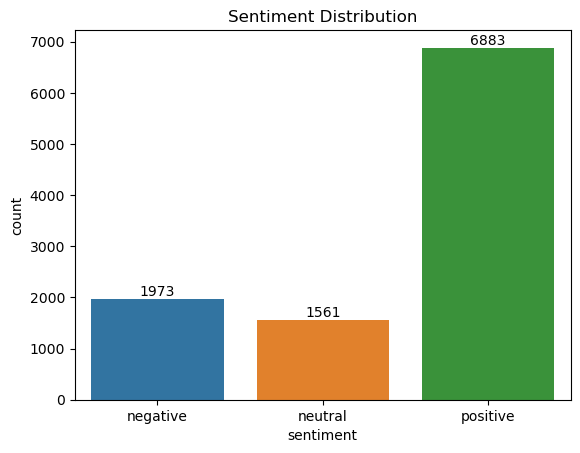

In [46]:
# Sentiment Distribution
ax = sns.countplot(x='sentiment', data=df)
ax.bar_label(ax.containers[0])
plt.title('Sentiment Distribution');

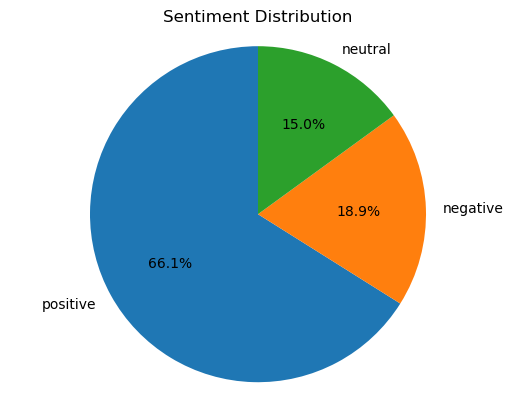

In [47]:
# Sentiment Distribution
sentiment_counts = df['sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()

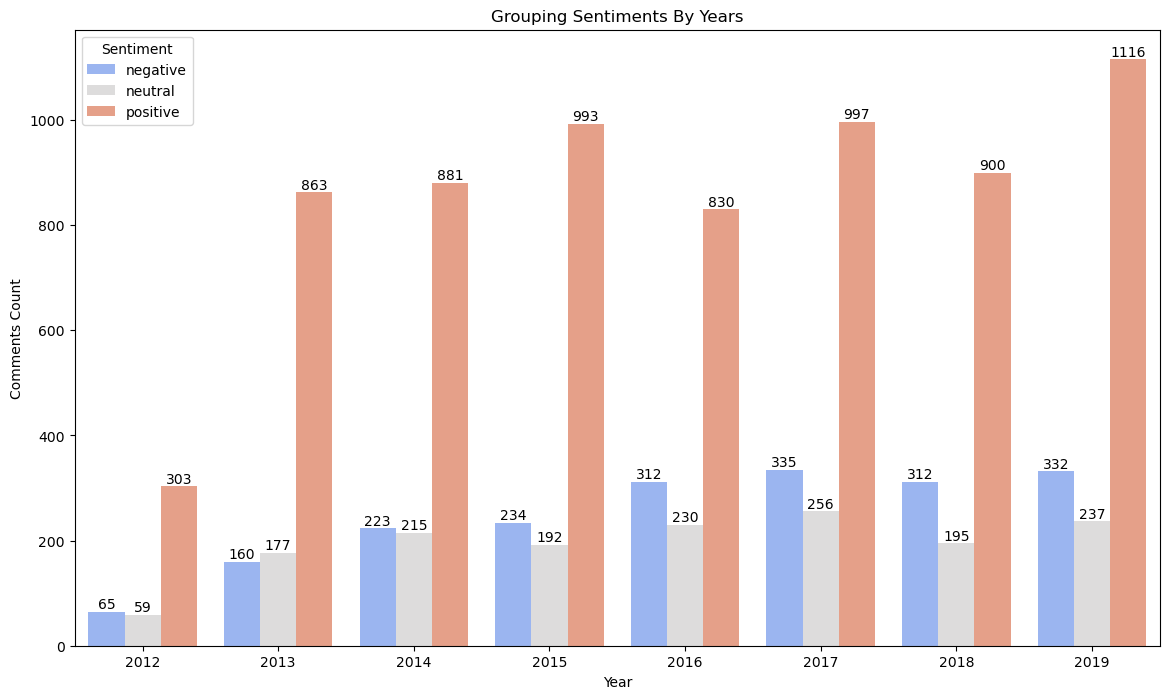

In [48]:
# Grouping sentiments by years
yearly_star_counts = df.groupby(['year', 'sentiment']).size().reset_index(name='count')
yearly_star_counts['year'] = yearly_star_counts['year'].astype(str)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='year', y='count', hue='sentiment', data=yearly_star_counts, palette='coolwarm')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.title('Grouping Sentiments By Years')
plt.xlabel('Year')
plt.ylabel('Comments Count')
plt.legend(title='Sentiment')
plt.show();

In [49]:
def wc(data, bgcolor):
    plt.figure(figsize = (10,10))
    mask = np.array(Image.open('cloud.png'))
    wc = WordCloud(background_color = bgcolor, stopwords= STOPWORDS, mask=mask)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [50]:
negative_comments = df[df['sentiment'] == 'negative']['text']
positive_comments = df[df['sentiment'] == 'positive']['text']
one_star_comments = df[df['stars'] == 1]['text']
five_star_comments = df[df['stars'] == 5]['text']

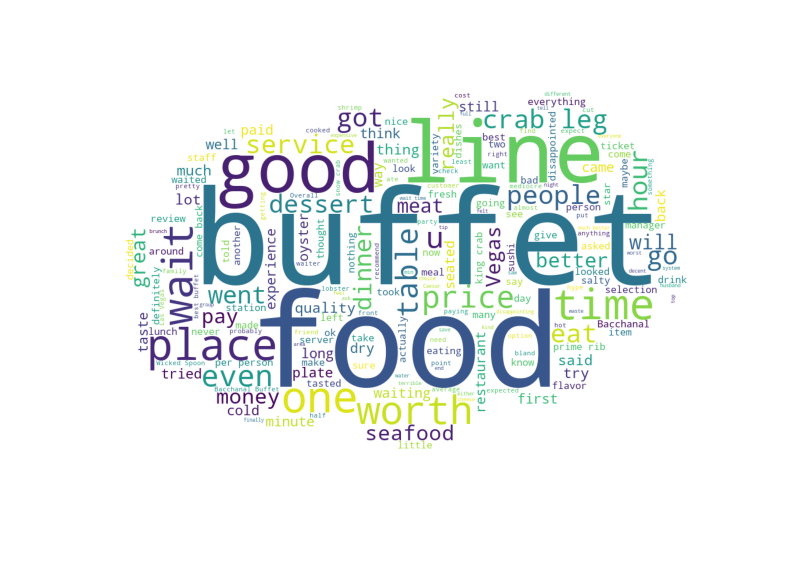

In [51]:
wc(negative_comments, 'white')

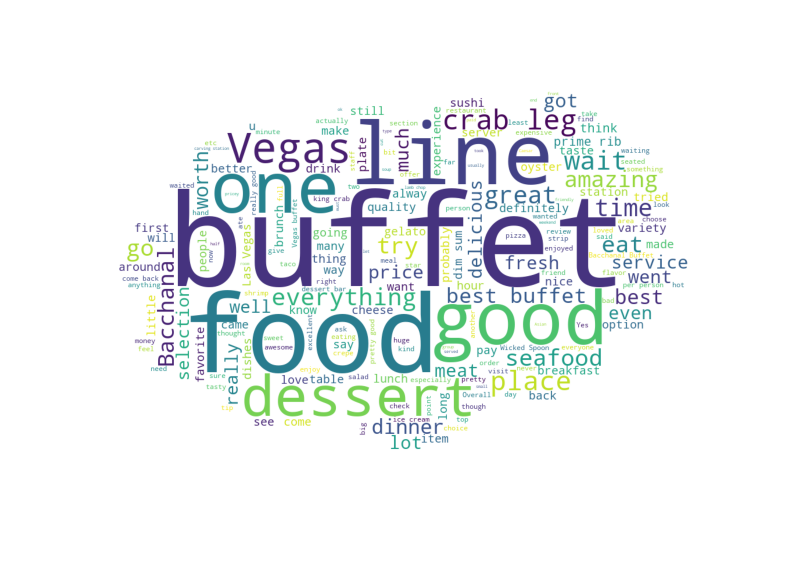

In [52]:
wc(positive_comments, 'white')

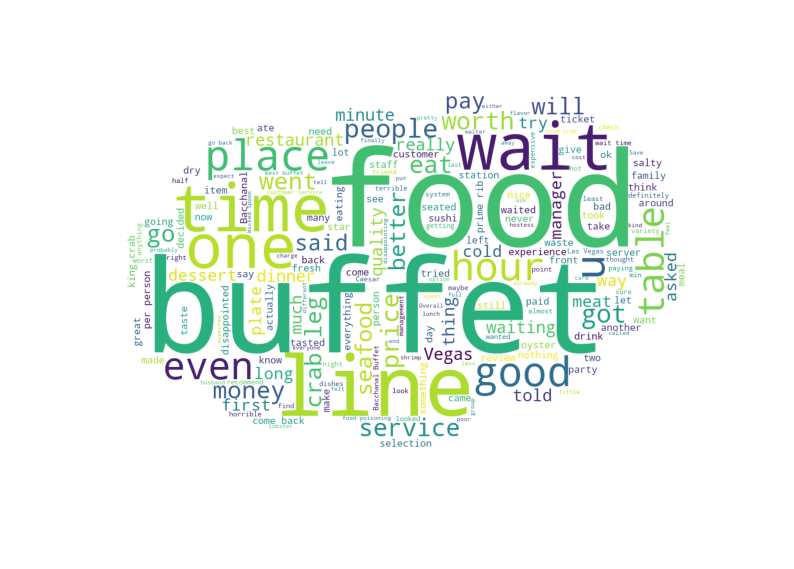

In [53]:
wc(one_star_comments, 'white')


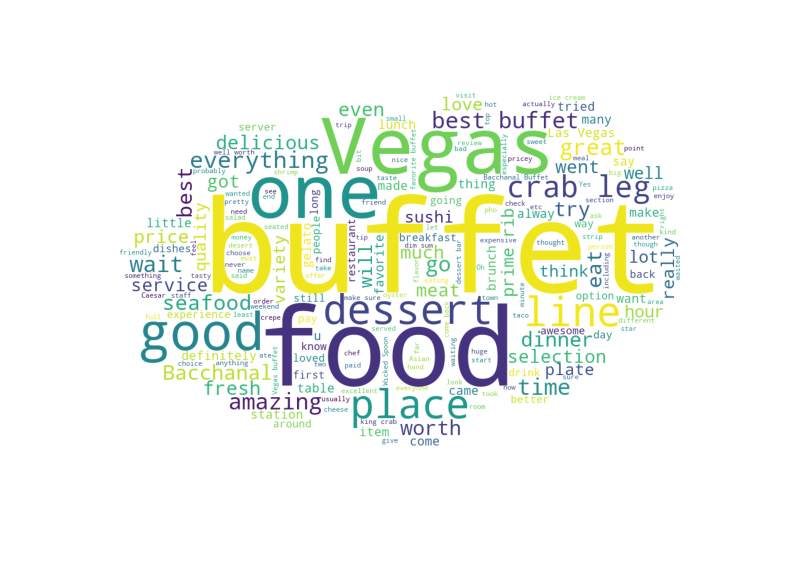

In [54]:
wc(five_star_comments, 'white')


### Text Preprocessing

In [55]:
df.head(2)

,stars,sentiment,useful,funny,cool,text,date,year
0,5,positive,0,1,0,After getting food poisoning at the Palms hote...,2012-12-04 03:10:18,2012
1,4,positive,39,21,29,"""A feast worthy of Gods""\n\nBaccarnal Buffet i...",2014-01-17 00:50:50,2014


In [56]:
df.text = df.text.str.lower()
df.text = df.text.str.replace('[^\w\s]','' , regex=True)
df.text = df.text.str.replace('\n','')
df.text = df.text.str.replace('\d+' , '' , regex=True)

In [57]:
df.head(2)

,stars,sentiment,useful,funny,cool,text,date,year
0,5,positive,0,1,0,after getting food poisoning at the palms hote...,2012-12-04 03:10:18,2012
1,4,positive,39,21,29,a feast worthy of godsbaccarnal buffet in caes...,2014-01-17 00:50:50,2014


### Detect Language

In [58]:
# detect language
from langdetect import detect
df['language'] = df['text'].apply(lambda x: detect(x))

In [59]:
df.language.value_counts()

language
en       10374
es          10
zh-cn        7
ja           7
ko           5
de           4
fr           4
da           2
sw           1
zh-tw        1
pt           1
sl           1
Name: count, dtype: int64

In [60]:
# Get non-English ones
df[df['language'] != 'en'].language.value_counts()

language
es       10
zh-cn     7
ja        7
ko        5
de        4
fr        4
da        2
sw        1
zh-tw     1
pt        1
sl        1
Name: count, dtype: int64

In [61]:
df[df['language'] != 'en'].shape

(43, 9)

In [62]:
df = df[df['language'] == 'en']

### Sentiment Analysis

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def algo_test(x, y):
    bnb = BernoulliNB()
    lr = LogisticRegression()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    gbc = GradientBoostingClassifier()
    knc = KNeighborsClassifier()
    mnb = MultinomialNB()
    ada = AdaBoostClassifier()
    
    algos = [bnb, lr, dt, rf, gbc, knc, mnb, ada]
    algo_names = ['BernoulliNB', 'LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'MultinomialNB', 'AdaBoostClassifier']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    
    best_accuracy = 0
    best_algo_index = 0
    
    for i, algo in enumerate(algos):
        p = algo.fit(x_train, y_train).predict(x_test)
        acc = accuracy_score(p, y_test)
        if acc > best_accuracy:
            best_accuracy = acc
            best_algo_index = i
    
    best_algo_name = algo_names[best_algo_index]
    best_algo = algos[best_algo_index]
    p = best_algo.fit(x_train, y_train).predict(x_test)
    
    print(f'Best Algorithm: {best_algo_name}')
    print('Confusion Matrix:\n', confusion_matrix(p, y_test))
    print('Classification Report:\n', classification_report(p, y_test))
    print('Accuracy Score:\n', accuracy_score(p, y_test))
    sns.heatmap(confusion_matrix(p, y_test), annot=True, cmap='coolwarm', fmt='d')


In [85]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


def algo_test_all(x,y):
        bnb=BernoulliNB()
        lr=LogisticRegression()
        dt=DecisionTreeClassifier()
        rf=RandomForestClassifier()
        gbc=GradientBoostingClassifier()
        knc=KNeighborsClassifier()
        mnb = MultinomialNB()
        ada = AdaBoostClassifier()
        

       
        
        algos=[bnb,lr,dt,rf,gbc,knc,mnb,ada]
        algo_names=['BernoulliNB','LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','GradientBoostingClassifier','KNeighborsClassifier', 'MultinomialNB', 'AdaBoostClassifier']
        
        x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.20,random_state=42)
        
        confusion_matrixes= []
        classification_reports= []
        accuracy_scores=[]        
        
        for algo in algos:
            p=algo.fit(x_train,y_train).predict(x_test)
            classification_reports.append(classification_report(p , y_test))
            confusion_matrixes.append(confusion_matrix(p , y_test))
            accuracy_scores.append(accuracy_score(p , y_test))

        for i in range(len(algo_names)):
            print('Algorithm:'+ '\n' , algo_names[i])
            print('Confusion Matrix:'+ '\n' , confusion_matrixes[i])
            print('Classification Report: '+ '\n' , classification_reports[i])
            print('Accuracy Score:'+ '\n' , accuracy_scores[i])
            print('************************************************************')

In [64]:
from nltk.stem import PorterStemmer
pr = PorterStemmer()

def lemmafn (text):
    words = TextBlob(text).words
    return [pr.stem(word) for word in words]    

In [86]:
# Without any preprocessing (ALL ALORITHMS)
vect = CountVectorizer()
x = df['text']
y = df['sentiment']
x = vect.fit_transform(x)
algo_test_all(x,y)

Algorithm:
 BernoulliNB
Confusion Matrix:
 [[ 132   38   18]
 [  29   61  137]
 [ 239  207 1214]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.33      0.70      0.45       188
     neutral       0.20      0.27      0.23       227
    positive       0.89      0.73      0.80      1660

    accuracy                           0.68      2075
   macro avg       0.47      0.57      0.49      2075
weighted avg       0.76      0.68      0.71      2075

Accuracy Score:
 0.6780722891566265
************************************************************
Algorithm:
 LogisticRegression
Confusion Matrix:
 [[ 265   80   30]
 [  87  127   89]
 [  48   99 1250]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.66      0.71      0.68       375
     neutral       0.42      0.42      0.42       303
    positive       0.91      0.89      0.90      1397

    accuracy                           0.79      20

Best Algorithm: LogisticRegression
Confusion Matrix:
 [[ 265   80   30]
 [  87  127   89]
 [  48   99 1250]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.66      0.71      0.68       375
     neutral       0.42      0.42      0.42       303
    positive       0.91      0.89      0.90      1397

    accuracy                           0.79      2075
   macro avg       0.66      0.67      0.67      2075
weighted avg       0.80      0.79      0.79      2075

Accuracy Score:
 0.7913253012048193


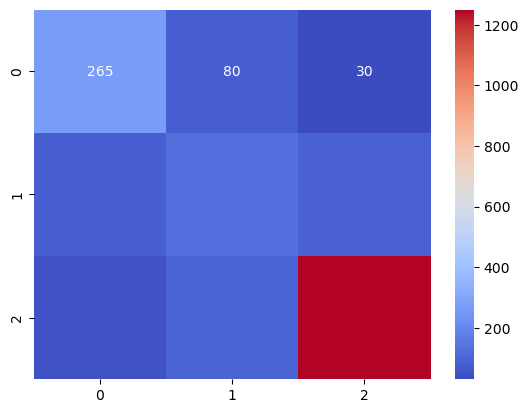

In [65]:
# Without any preprocessing
vect = CountVectorizer()
x = df['text']
y = df['sentiment']
x = vect.fit_transform(x)
algo_test(x,y)

Best Algorithm: LogisticRegression
Confusion Matrix:
 [[ 275   88   37]
 [  78  114   84]
 [  47  104 1248]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.69      0.69      0.69       400
     neutral       0.37      0.41      0.39       276
    positive       0.91      0.89      0.90      1399

    accuracy                           0.79      2075
   macro avg       0.66      0.66      0.66      2075
weighted avg       0.80      0.79      0.79      2075

Accuracy Score:
 0.7889156626506024


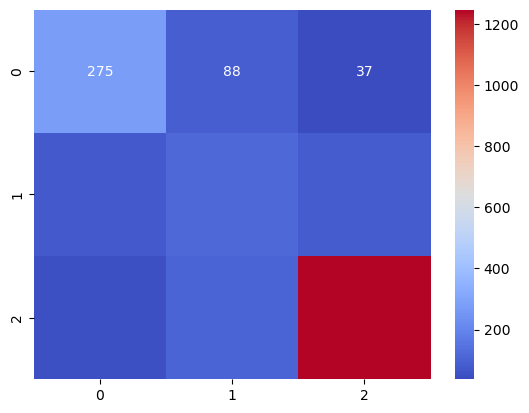

In [66]:
# With Lemmatization and Stemming
vect = CountVectorizer(stop_words='english', ngram_range=(1,2), analyzer=lemmafn)
x = df['text']
y = df['sentiment']
x = vect.fit_transform(x)
algo_test(x,y)

Best Algorithm: LogisticRegression
Confusion Matrix:
 [[ 275   88   37]
 [  78  114   84]
 [  47  104 1248]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.69      0.69      0.69       400
     neutral       0.37      0.41      0.39       276
    positive       0.91      0.89      0.90      1399

    accuracy                           0.79      2075
   macro avg       0.66      0.66      0.66      2075
weighted avg       0.80      0.79      0.79      2075

Accuracy Score:
 0.7889156626506024


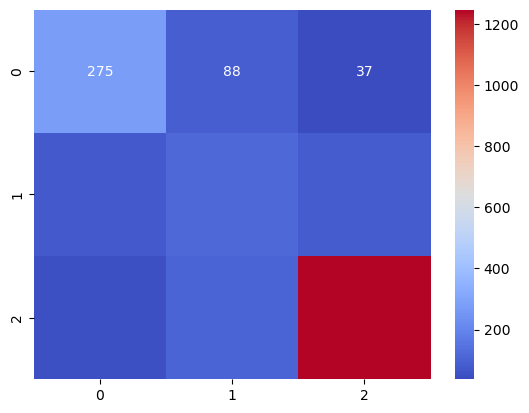

In [67]:
# With Lemmatization and Stemming and without ngram
vect = CountVectorizer(stop_words='english', analyzer=lemmafn)
x = df['text']
y = df['sentiment']
x = vect.fit_transform(x)
algo_test(x,y)

Best Algorithm: LogisticRegression
Confusion Matrix:
 [[ 284   83   19]
 [  47   76   26]
 [  69  147 1324]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.74      0.72       386
     neutral       0.25      0.51      0.33       149
    positive       0.97      0.86      0.91      1540

    accuracy                           0.81      2075
   macro avg       0.64      0.70      0.66      2075
weighted avg       0.87      0.81      0.83      2075

Accuracy Score:
 0.811566265060241


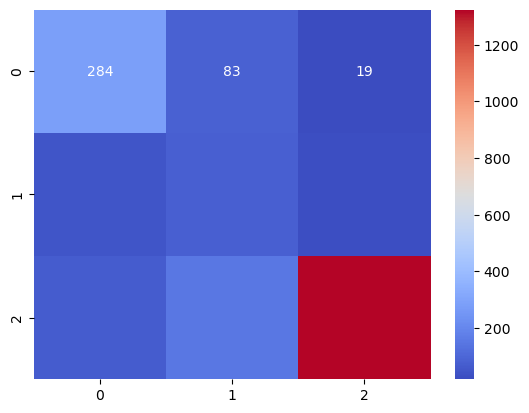

In [68]:
# with tfidf
tfidf_vect = TfidfVectorizer()
x = df['text']
y = df['sentiment']
x = tfidf_vect.fit_transform(x)
algo_test(x,y)

Best Algorithm: LogisticRegression
Confusion Matrix:
 [[ 248   72    9]
 [  31   52   12]
 [ 121  182 1348]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.62      0.75      0.68       329
     neutral       0.17      0.55      0.26        95
    positive       0.98      0.82      0.89      1651

    accuracy                           0.79      2075
   macro avg       0.59      0.71      0.61      2075
weighted avg       0.89      0.79      0.83      2075

Accuracy Score:
 0.7942168674698795


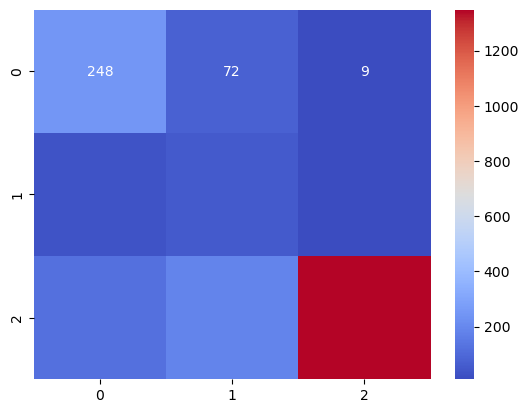

In [69]:
# with tfidf with ngram
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
x = df['text']
y = df['sentiment']
x = tfidf_vect.fit_transform(x)
algo_test(x,y)

In [76]:
#negative one word
from collections import Counter
negative_comments = df[df['sentiment'] == 'negative']['text']

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(negative_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_words_negative = Counter(tfidf_scores).most_common(10)
df_top_words = pd.DataFrame(top_words_negative, columns=['Word', 'Count'])
df_top_words

,Word,Count
0,food,104.861894
1,buffet,94.676277
2,line,72.289605
3,wait,65.301494
4,good,65.248317
5,time,56.789685
6,crab,55.435426
7,just,53.019666
8,worth,50.281589
9,place,49.593799


In [79]:
# negative bigrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

negative_comments = df[df['sentiment'] == 'negative']['text']

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
tfidf_matrix = tfidf.fit_transform(negative_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_bigrams_negative = Counter(tfidf_scores).most_common(10)
df_top_words = pd.DataFrame(top_bigrams_negative, columns=['Word', 'Count'])
df_top_words

,Word,Count
0,crab legs,21.934999
1,prime rib,12.975729
2,king crab,11.742702
3,wicked spoon,10.461644
4,food good,9.377464
5,quality food,9.322912
6,wait line,8.834647
7,las vegas,8.356514
8,buffet vegas,8.232308
9,worth price,7.798023


In [80]:
# negative trigrams

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

negative_comments = df[df['sentiment'] == 'negative']['text']

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(3, 3))
tfidf_matrix = tfidf.fit_transform(negative_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_trigrams_negative = Counter(tfidf_scores).most_common(10)
df_top_words = pd.DataFrame(top_trigrams_negative, columns=['Word', 'Count'])
df_top_words

,Word,Count
0,king crab legs,5.212265
1,best buffet vegas,3.643329
2,snow crab legs,3.254084
3,dont waste money,2.502796
4,got food poisoning,2.440311
5,buffet las vegas,2.271294
6,definitely worth price,2.112979
7,waste time money,1.967980
8,wicked spoon better,1.963430
9,dont waste time,1.843569


In [81]:
#positive one word
from collections import Counter
positive_comments = df[df['sentiment'] == 'positive']['text']

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(positive_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_words_positive = Counter(tfidf_scores).most_common(10)
df_top_words = pd.DataFrame(top_words_positive, columns=['Word', 'Count'])
df_top_words

,Word,Count
0,buffet,374.680095
1,food,328.464071
2,good,247.433726
3,vegas,236.254592
4,best,228.956604
5,great,212.690952
6,worth,187.585612
7,wait,185.324094
8,crab,184.095803
9,time,180.453338


In [82]:
# positive bigrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

positive_comments = df[df['sentiment'] == 'positive']['text']

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
tfidf_matrix = tfidf.fit_transform(positive_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_bigrams_positive = Counter(tfidf_scores).most_common(10)
df_top_words = pd.DataFrame(top_bigrams_positive, columns=['Word', 'Count'])
df_top_words

,Word,Count
0,best buffet,84.134389
1,crab legs,83.175687
2,buffet vegas,54.327040
3,las vegas,45.742619
4,prime rib,44.122711
5,bacchanal buffet,29.509163
6,wicked spoon,28.801195
7,quality food,28.360059
8,dim sum,27.029945
9,king crab,26.682345


In [83]:
# positive trigramss
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

positive_comments = df[df['sentiment'] == 'positive']['text']

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(3, 3))
tfidf_matrix = tfidf.fit_transform(positive_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_trigrams_positive = Counter(tfidf_scores).most_common(10)
df_top_words = pd.DataFrame(top_trigrams_positive, columns=['Word', 'Count'])
df_top_words

,Word,Count
0,best buffet vegas,33.571736
1,buffet las vegas,20.782891
2,best buffet ive,17.827400
3,king crab legs,16.786597
4,best buffet las,15.436460
5,hands best buffet,10.882494
6,favorite buffet vegas,10.222658
7,best buffet strip,9.632903
8,far best buffet,9.491185
9,snow crab legs,8.709858


In [87]:
methods = ['CountVectorizer', 'CountVectorizer', 'CountVectorizer N-Grams', 'TF-IDF', 'TF-IDF N-Grams']

algorithms =['LogisticRegression', 'MultinomialNB', 'LogisticRegression', 'LogisticRegression', 'LogisticRegression'] 

accuracies = ['79.1325', '77.3975', '78.8915', '79.1325', '79.1325', '81.1566', '79.4216']